# **IEOR E4650  Business Analytics (Fall 2021)**

Project Name: Campaign Strategy


Team Members: Shijia Liu(sl4819), Yao Yi (yy3097), Jiaqi Zhang (jz3284), Yazhe Zhang(yz3954)

## Import Data

In [ ]:
#Import the library, authenticate, and create the interface to csv files.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import poisson
import matplotlib.pyplot as plt
from statsmodels.base.model import GenericLikelihoodModel
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import logit
import copy
import scipy.stats as spst

In [ ]:
## change the link to the link to your csv file on Google Drive
# link="https://drive.google.com/open?id=17Sa-DuRFCWfPzCW6uRbPwxAyo1mQARUn"
# _,id=link.split("=")
link='https://drive.google.com/file/d/128s5Rz5U3QKYEtbqQ9hjeFpV_C5vHjEJ'
_,id=link.split("/d/")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('marketing_campaign.csv')  
data = pd.read_csv('marketing_campaign.csv',sep='\t')
data

## Data Preprocessing

In [ ]:
from dataclasses import dataclass
# get dummies for categorical data
educations = pd.get_dummies(data.Education,prefix='E')
marital = pd.get_dummies(data.Marital_Status,prefix='M')
data = pd.concat([data,educations,marital],axis=1)

# log transform income
data['log_Income'] = data.Income.apply(lambda x:np.log(x))

# add columns for modeling
data['NumTotalPurchases']=data['NumStorePurchases']+data['NumWebPurchases']+data['NumCatalogPurchases']
data['DealsPercentage']=np.where(data['NumTotalPurchases']>0,data['NumDealsPurchases']/data['NumTotalPurchases'],0)
data['TotalAccept']=data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']\
            +data['AcceptedCmp1']+data['AcceptedCmp2']+data['Response']
data['LargerWeb']=np.where(data['NumWebPurchases']>data['NumStorePurchases'],1,0)

data['age'] = data.Year_Birth.apply(lambda x:2021-int(x))
data = data.astype({'Dt_Customer':'datetime64'})
data['duration'] = (pd.Timestamp('2021-06-30')-data['Dt_Customer']).dt.days

data['total_amount'] = data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']
data['wine_rate']=np.where(data['total_amount']>0,data['MntWines']/data['total_amount'],0)
data['fruit_rate']=np.where(data['total_amount']>0,data['MntFruits']/data['total_amount'],0)
data['meat_rate']=np.where(data['total_amount']>0,data['MntMeatProducts']/data['total_amount'],0)
data['fish_rate']=np.where(data['total_amount']>0,data['MntFishProducts']/data['total_amount'],0)
data['sweet_rate']=np.where(data['total_amount']>0,data['MntSweetProducts']/data['total_amount'],0)
data['gold_rate']=np.where(data['total_amount']>0,data['MntGoldProds']/data['total_amount'],0)

data['Together'] = np.where((data['Marital_Status']=='Together')|(data['Marital_Status']=='Married'),1,0)
# data["Education1"]=data["Education"]
data["Education"]=data["Education"].replace({"Basic":1,"2n Cycle":1, "Graduation":2, "Master":2, "PhD":3})
# data["Education1"]=data["Education1"].replace({"Basic":1,"2n Cycle":1, "Graduation":2, "Master":2, "PhD":3})
data['kid_teen'] = data['Teenhome']+data['Kidhome']

# data = data.drop(['Education','Marital_Status','Z_CostContact','Z_Revenue'],axis=1)
# data.rename(columns={"Education1":"Education"},inplace=True)

# deal with null data
data = data.dropna()

data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,E_2n Cycle,E_Basic,E_Graduation,E_Master,E_PhD,M_Absurd,M_Alone,M_Divorced,M_Married,M_Single,M_Together,M_Widow,M_YOLO,log_Income,NumTotalPurchases,DealsPercentage,TotalAccept,LargerWeb,age,duration,total_amount,wine_rate,fruit_rate,meat_rate,fish_rate,sweet_rate,gold_rate,Together,kid_teen
0,5524,1957,2,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,0,0,1,0,0,0,0,0,0,1,0,0,0,10.970575,22,0.136364,1,1,64,3369,1617,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,0,0
1,2174,1954,2,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,0,0,1,0,0,0,0,0,0,1,0,0,0,10.743847,4,0.500000,0,0,67,2523,27,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,0,2
2,4141,1965,2,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,11.179032,20,0.050000,0,0,56,2870,776,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,1,0
3,6182,1984,2,Together,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,10.190394,6,0.333333,0,0,37,2463,53,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,1,1
4,5324,1981,3,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,0,0,0,0,1,0,0,0,1,0,0,0,0,10.973237,14,0.357143,0,0,40,2719,422,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,0,0,1,0,0,0,0,0,1,0,0,0,0,11.022278,16,0.125000,0,1,54,2939,1341,0.528710,0.032066,0.135720,0.031320,0.087994,0.184191,1,1
2236,4001,1946,3,Together,64014.0,2,1,2014-10-06,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,0,0,0,0,1,0,0,0,0,0,1,0,0,11.066857,15,0.466667,1,1,75,2459,444,0.914414,0.000000,0.067568,0.000000,0.000000,0.018018,1,3
2237,7270,1981,2,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,0,0,1,0,0,0,0,1,0,0,0,0,0,10.950473,18,0.055556,1,0,40,2713,1241,0.731668,0.038678,0.174859,0.025786,0.009670,0.019339,0,0
2238,8235,1956,2,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,0,0,0,1,0,0,0,0,0,0,1,0,0,11.145406,21,0.095238,0,0,65,2714,843,0.507711,0.035587,0.253855,0.094899,0.035587,0.072361,1,1


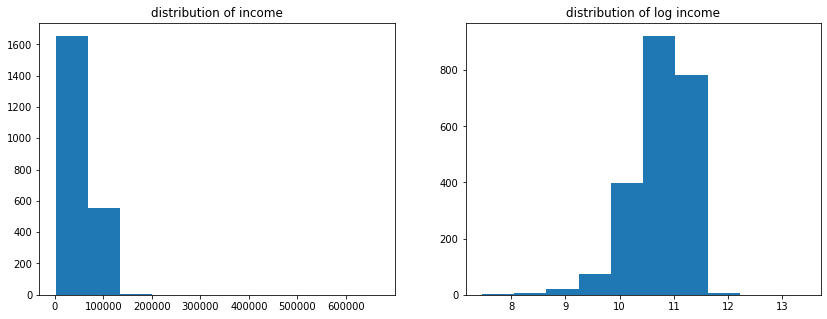

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(data.Income)
plt.title('distribution of income')
plt.subplot(122)
plt.hist(data.log_Income)
plt.title('distribution of log income')
plt.show()

## Probability attending future campaign

In [ ]:
# response~other variables (logistic reg)
data.rename(columns={"E_2n Cycle":"E_2n_Cycle"},inplace=True)
cols = list(data.columns)
print(cols)

['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'E_2n_Cycle', 'E_Basic', 'E_Graduation', 'E_Master', 'E_PhD', 'M_Absurd', 'M_Alone', 'M_Divorced', 'M_Married', 'M_Single', 'M_Together', 'M_Widow', 'M_YOLO', 'log_Income', 'NumTotalPurchases', 'DealsPercentage', 'TotalAccept', 'LargerWeb', 'age', 'duration', 'total_amount', 'wine_rate', 'fruit_rate', 'meat_rate', 'fish_rate', 'sweet_rate', 'gold_rate', 'Together', 'kid_teen']


In [ ]:
x = ['Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts',
'MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases',
'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','E_2n_Cycle',
'E_Basic','E_Graduation','E_Master','E_PhD','M_Absurd','M_Alone','M_Divorced','M_Married',
'M_Single','M_Together','M_Widow','M_YOLO','log_Income','DealsPercentage',
'LargerWeb','age','duration']
def construct_m(variables):
    model= "Response~" +variables[0]
    for i in range(1,len(variables)):
        model=model+"+"+variables[i]  
    return model

In [ ]:
# model using all variables at first
cmp = ['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2']
x1 = cmp+x
model=construct_m(x1)
model_cmp_all = logit(model,data).fit(method="newton")
model_cmp_all.summary()

Optimization terminated successfully.
         Current function value: 0.251543
         Iterations 12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 2216
Model:                          Logit   Df Residuals:                     2179
Method:                           MLE   Df Model:                           36
Date:                Wed, 29 Dec 2021   Pseudo R-squ.:                  0.4056
Time:                        17:18:42   Log-Likelihood:                -557.42
converged:                       True   LL-Null:                       -937.76
Covariance Type:            nonrobust   LLR p-value:                1.414e-136
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -12.4414        nan        nan        nan         nan         nan
AcceptedCmp3            2.0223      0.237      8.522      0.000       1.557       2.487
AcceptedCmp4            1.2233      0.300      4.080      0.000       0.636       1.811
AcceptedCmp5            1.8396      0.297      6.191      0.000       1.257       2.422
AcceptedCmp1            1.5560      0.292      5.333      0.000       0.984       2.128
AcceptedCmp2            1.6671      0.560      2.977      0.003       0.570       2.765
Kidhome                 0.2320      0.223      1.042      0.297      -0.204       0.669
Teenhome               -1.0949      0.210     -5.221      0.000      -1.506      -0.684
Recency                -0.0313      0.003    -10.378      0.000      -0.037      -0.025
MntWines               -0.0005      0.000     -1.325      0.185      -0.001       0.000
MntFruits               0.0028      0.002      1.174      0.240      -0.002       0.007
MntMeatProducts         0.0022      0.001      4.218      0.000       0.001       0.003
MntFishProducts        -0.0019      0.002     -1.002      0.316      -0.006       0.002
MntSweetProducts        0.0010      0.002      0.418      0.676      -0.004       0.006
MntGoldProds            0.0032      0.002      1.923      0.054   -6.07e-05       0.006
NumDealsPurchases       0.1229      0.050      2.436      0.015       0.024       0.222
NumWebPurchases         0.0538      0.043      1.246      0.213      -0.031       0.138
NumCatalogPurchases     0.0428      0.042      1.016      0.310      -0.040       0.125
NumStorePurchases      -0.1517      0.041     -3.713      0.000      -0.232      -0.072
NumWebVisitsMonth       0.1574      0.053      2.954      0.003       0.053       0.262
Complain               -0.0547      1.068     -0.051      0.959      -2.148       2.039
E_2n_Cycle             -2.8260   4.82e+06  -5.87e-07      1.000   -9.44e+06    9.44e+06
E_Basic                -3.8047   4.82e+06   -7.9e-07      1.000   -9.44e+06    9.44e+06
E_Graduation           -2.4472   4.82e+06  -5.08e-07      1.000   -9.44e+06    9.44e+06
E_Master               -2.0431   4.81e+06  -4.24e-07      1.000   -9.44e+06    9.44e+06
E_PhD                  -1.4369   4.82e+06  -2.98e-07      1.000   -9.44e+06    9.44e+06
M_Absurd               -0.6546   5.17e+06  -1.27e-07      1.000   -1.01e+07    1.01e+07
M_Alone                -0.2752   5.17e+06  -5.32e-08      1.000   -1.01e+07    1.01e+07
M_Divorced             -1.3841   5.17e+06  -2.68e-07      1.000   -1.01e+07    1.01e+07
M_Married              -2.6778   5.17e+06  -5.18e-07      1.000   -1.01e+07    1.01e+07
M_Single               -1.3328   5.17e+06  -2.58e-07      1.000   -1.01e+07    1.01e+07
M_Together             -2.6920   5.17e+06   -5.2e-07      1.000   -1.01e+07    1.01e+07
M_Widow                -1.3806   5.17e+06  -2.67e-07      1.000   -1.01e+07    1.01e+07
M_YOLO                 -2.0637   5.17e+06  -3.99e-07      1.000   -1.01e+

In [ ]:
# remove insignificant variables
x1_copy=copy.copy(x1)
for i in range(1,len(model_cmp_all.pvalues)): 
    if model_cmp_all.pvalues[i] >= 0.05: 
        rem = x1[i-1]
        x1_copy.remove(rem)
model=construct_m(x1_copy)
model_cmp_all_insig = logit(model,data).fit(method="newton")
model_cmp_all_insig.summary()

Optimization terminated successfully.
         Current function value: 0.282535
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 2216
Model:                          Logit   Df Residuals:                     2203
Method:                           MLE   Df Model:                           12
Date:                Wed, 29 Dec 2021   Pseudo R-squ.:                  0.3323
Time:                        17:18:48   Log-Likelihood:                -626.10
converged:                       True   LL-Null:                       -937.76
Covariance Type:            nonrobust   LLR p-value:                1.101e-125
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.5082      1.037    -10.129      0.000     -12.542      -8.475
AcceptedCmp3          2.0396      0.214      9.531      0.000       1.620       2.459
AcceptedCmp4          1.1635      0.267      4.361      0.000       0.641       1.686
AcceptedCmp5          1.6260      0.260      6.254      0.000       1.116       2.136
AcceptedCmp1          1.4118      0.261      5.415      0.000       0.901       1.923
AcceptedCmp2          1.3313      0.512      2.598      0.009       0.327       2.335
Teenhome             -0.6650      0.169     -3.927      0.000      -0.997      -0.333
Recency              -0.0289      0.003    -10.253      0.000      -0.034      -0.023
MntMeatProducts       0.0026      0.000      6.460      0.000       0.002       0.003
NumDealsPurchases     0.1262      0.041      3.058      0.002       0.045       0.207
NumStorePurchases    -0.1103      0.029     -3.756      0.000      -0.168      -0.053
NumWebVisitsMonth     0.1103      0.041      2.690      0.007       0.030       0.191
duration              0.0030      0.000      8.297      0.000       0.002       0.004
=====================================================================================
"""

In [ ]:
# repeat last procedure for ensuring
# final model
x1_copy2=copy.copy(x1_copy)
for i in range(1,len(model_cmp_all_insig.pvalues)): 
    if model_cmp_all_insig.pvalues[i] >= 0.05: 
        rem = x1_copy[i-1]
        x1_copy2.remove(rem)
model=construct_m(x1_copy2)
model_cmp_all_insig = logit(model,data).fit(method="newton")
model_cmp_all_insig.summary()

Optimization terminated successfully.
         Current function value: 0.282535
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 2216
Model:                          Logit   Df Residuals:                     2203
Method:                           MLE   Df Model:                           12
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  0.3323
Time:                        04:24:37   Log-Likelihood:                -626.10
converged:                       True   LL-Null:                       -937.76
Covariance Type:            nonrobust   LLR p-value:                1.101e-125
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.5082      1.037    -10.129      0.000     -12.542      -8.475
AcceptedCmp3          2.0396      0.214      9.531      0.000       1.620       2.459
AcceptedCmp4          1.1635      0.267      4.361      0.000       0.641       1.686
AcceptedCmp5          1.6260      0.260      6.254      0.000       1.116       2.136
AcceptedCmp1          1.4118      0.261      5.415      0.000       0.901       1.923
AcceptedCmp2          1.3313      0.512      2.598      0.009       0.327       2.335
Teenhome             -0.6650      0.169     -3.927      0.000      -0.997      -0.333
Recency              -0.0289      0.003    -10.253      0.000      -0.034      -0.023
MntMeatProducts       0.0026      0.000      6.460      0.000       0.002       0.003
NumDealsPurchases     0.1262      0.041      3.058      0.002       0.045       0.207
NumStorePurchases    -0.1103      0.029     -3.756      0.000      -0.168      -0.053
NumWebVisitsMonth     0.1103      0.041      2.690      0.007       0.030       0.191
duration              0.0030      0.000      8.297      0.000       0.002       0.004
=====================================================================================
"""

In [ ]:
# variables
print('Variables used for final model and their coefficients:',model_cmp_all_insig.params)

Variables used for final model and their coefficients: Intercept           -10.508199
AcceptedCmp3          2.039631
AcceptedCmp4          1.163462
AcceptedCmp5          1.625963
AcceptedCmp1          1.411791
AcceptedCmp2          1.331274
Teenhome             -0.664970
Recency              -0.028881
MntMeatProducts       0.002596
NumDealsPurchases     0.126207
NumStorePurchases    -0.110261
NumWebVisitsMonth     0.110256
duration              0.002960
dtype: float64


## PREDICT NumDealPurchases

In [ ]:
# use forward stepwise to select vars for poisson model

In [ ]:
var = ['Kidhome', 'Teenhome', 
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
       'Complain', 'Response', 'C(E_Basic)', 'C(E_Graduation)',
       'C(E_Master)', 'C(E_PhD)', 'C(M_Alone)', 'C(M_Divorced)', 'C(M_Married)',
       'C(M_Single)', 'C(M_Together)', 'C(M_Widow)', 'C(M_YOLO)', 'log_Income',
       'TotalAccept', 'C(LargerWeb)','age']

In [ ]:
model = 'NumDealsPurchases~'
best_llf = -10000
llf = []
add_var = []
add = ''

for i in range(len(var)):
    print(i)
    for j in range(len(var)):
        print(j)
        if not j and not i:
            model_use = model+var[j]
        else:
            model_use = model+'+'+var[j]
            print(model_use)
        poisson_m = poisson(model_use,data).fit(maxiter=5000)
        if poisson_m.llf > best_llf:
            best_llf = poisson_m.llf
            llf.append(best_llf)
            add = var[j]
    add_var.append(add)
    
    if i>0 and llf[i] <= llf[i-1]:
        break
    else:
        if i==0:
            model = model+add
        else:
            model = model+'+'+add
        print(model)
        var.remove(add)

In [ ]:
model = 'NumDealsPurchases~'+'+'.join(add_var)
poisson_m = poisson(model,data).fit(maxiter=5000)
poisson_m.summary()

Optimization terminated successfully.
         Current function value: 1.566897
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:      NumDealsPurchases   No. Observations:                 2216
Model:                        Poisson   Df Residuals:                     2186
Method:                           MLE   Df Model:                           29
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  0.1705
Time:                        05:47:57   Log-Likelihood:                -3472.2
converged:                       True   LL-Null:                       -4186.2
Covariance Type:            nonrobust   LLR p-value:                1.327e-282
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.8887      0.707      2.672      0.008       0.503       3.274
C(LargerWeb)[T.1]        0.2914      0.039      7.499      0.000       0.215       0.368
C(E_PhD)[T.1]           -0.1159      0.059     -1.958      0.050      -0.232       0.000
C(M_Single)[T.1]        -0.7007      0.508     -1.379      0.168      -1.696       0.295
C(E_Graduation)[T.1]    -0.0629      0.052     -1.213      0.225      -0.165       0.039
C(M_YOLO)[T.1]          -0.3608      0.602     -0.600      0.549      -1.540       0.819
C(M_Divorced)[T.1]      -0.6906      0.509     -1.356      0.175      -1.689       0.307
C(M_Together)[T.1]      -0.6661      0.508     -1.311      0.190      -1.662       0.330
C(M_Alone)[T.1]         -0.4646      0.591     -0.786      0.432      -1.623       0.694
C(E_Master)[T.1]        -0.0387      0.060     -0.646      0.519      -0.156       0.079
C(M_Married)[T.1]       -0.6483      0.508     -1.277      0.202      -1.644       0.347
C(M_Widow)[T.1]         -0.6242      0.512     -1.218      0.223      -1.629       0.380
C(E_Basic)[T.1]         -0.0426      0.115     -0.370      0.711      -0.269       0.183
Teenhome                 0.5449      0.030     18.116      0.000       0.486       0.604
NumWebVisitsMonth        0.1067      0.008     12.625      0.000       0.090       0.123
NumStorePurchases        0.0975      0.007     13.577      0.000       0.083       0.112
Kidhome                  0.4510      0.031     14.377      0.000       0.390       0.513
NumCatalogPurchases      0.0767      0.008      9.520      0.000       0.061       0.093
log_Income              -0.1941      0.045     -4.341      0.000      -0.282      -0.106
MntWines                -0.0002   7.91e-05     -2.252      0.024      -0.000   -2.31e-05
MntFruits               -0.0015      0.001     -2.728      0.006      -0.003      -0.000
MntGoldProds             0.0010      0.000      3.125      0.002       0.000       0.002
TotalAccept             -0.1652      0.030     -5.562      0.000      -0.223      -0.107
Response                 0.3109      0.061      5.104      0.000       0.192       0.430
MntFishProducts         -0.0008      0.000     -2.060      0.039      -0.002   -4.13e-05
age                     -0.0024      0.001     -1.661      0.097      -0.005       0.000
MntSweetProducts        -0.0009      0.001     -1.712      0.087      -0.002       0.000
MntMeatProducts          0.0001      0.000      0.975      0.329      -0.000       0.000
Complain                -0.1042      0.144     -0.721      0.471      -0.387       0.179
Recency                  0.0002      0.001      0.491      0.624      -0.001       0.001
========================================================================================
"""

In [ ]:
# use forward stepwise to select vars for NBD model

In [ ]:
var = ['Kidhome', 'Teenhome', 
       'Recency', 'MntWines', 'MntFruits',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
       'Response', 'log_Income','E_Basic', 'E_Graduation',
       'E_Master', 'E_PhD',
       'TotalAccept', 'LargerWeb']

In [ ]:
class NBD_cov(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog
        gamma=np.exp(params[0])
        alpha = np.exp(params[1])
        xparam = 0
        for i in range(x.shape[1]):
            xparam += params[2+i]*x[:,i]
        alpha = alpha/np.exp(xparam)
        Likelihood=spst.nbinom.pmf(y,n=gamma,p=alpha/(1+alpha)) 
        LogLike=np.log(Likelihood)
        return np.sum(LogLike)


In [ ]:
best_llf = -10000
llf = []
add_var = []
add = ''

for i in range(len(var)):
    print(i)
    for j in range(len(var)):
        print(j)
        print(var)
        print(var[j])
        add_var.append(var[j])
        print(add_var)
        model_used=NBD_cov(data['NumDealsPurchases'],data[add_var]).fit(start_params=[0]*(len(add_var)+2),maxiter=25000)
        print(model_used.summary())
        print(model_used.llf)
        if model_used.llf > best_llf:
            best_llf = model_used.llf
            llf.append(best_llf)
            add = var[j]
        add_var.remove(var[j])
    add_var.append(add)
    print(llf)
    
    if i>0 and llf[i] <= llf[i-1]:
        print('here')
        break
    else:
        print('here')
        print(add_var)
        print(add)
        print('pre',var)
        if add not in var:
            break
        else:
            var.remove(add)
        print(var)

0
0
['Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'log_Income', 'E_Basic', 'E_Graduation', 'E_Master', 'E_PhD', 'TotalAccept', 'LargerWeb']
Kidhome
['Kidhome']
Optimization terminated successfully.
         Current function value: 1.822879
         Iterations: 181
         Function evaluations: 328
                               NBD_cov Results                                
Dep. Variable:      NumDealsPurchases   Log-Likelihood:                -4039.5
Model:                        NBD_cov   AIC:                             8081.
Method:            Maximum Likelihood   BIC:                             8087.
Date:                Wed, 29 Dec 2021                                         
Time:                        15:46:44                                         
No. Observations:                2216                        

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 1.734452
         Iterations: 749
         Function evaluations: 1171
                               NBD_cov Results                                
Dep. Variable:      NumDealsPurchases   Log-Likelihood:                -3843.5
Model:                        NBD_cov   AIC:                             7695.
Method:            Maximum Likelihood   BIC:                             7718.
Date:                Wed, 29 Dec 2021                                         
Time:                        15:47:25                                         
No. Observations:                2216                                         
Df Residuals:                    2212                                         
Df Model:                           3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [ ]:
add_var

['Teenhome',
 'NumWebVisitsMonth',
 'NumWebPurchases',
 'MntGoldProds',
 'Recency',
 'Recency']

In [ ]:
NBD_cov(data['NumDealsPurchases'],data[add_var[:-1]]).fit(start_params=[0]*(len(add_var[:-1])+2),maxiter=25000).summary()

Optimization terminated successfully.
         Current function value: 1.664965
         Iterations: 1527
         Function evaluations: 2296


<class 'statsmodels.iolib.summary.Summary'>
"""
                               NBD_cov Results                                
==============================================================================
Dep. Variable:      NumDealsPurchases   Log-Likelihood:                -3689.6
Model:                        NBD_cov   AIC:                             7389.
Method:            Maximum Likelihood   BIC:                             7418.
Date:                Wed, 29 Dec 2021                                         
Time:                        01:27:57                                         
No. Observations:                2216                                         
Df Residuals:                    2211                                         
Df Model:                           4                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Teenhome              3.6456      0.372      9.806      0.000       2.917       4.374
NumWebVisitsMonth     3.9840      0.374     10.667      0.000       3.252       4.716
NumWebPurchases       0.4795      0.027     18.015      0.000       0.427       0.532
MntGoldProds          0.1149      0.006     19.043      0.000       0.103       0.127
Recency               0.0491      0.005      9.092      0.000       0.038       0.060
par0                  0.0007      0.000      2.415      0.016       0.000       0.001
par1              -1.648e-05      0.001     -0.033      0.974      -0.001       0.001
=====================================================================================
"""

In [ ]:
important_var = ['Kidhome', 'Teenhome','MntFruits','MntGoldProds',
       'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 
       'NumWebVisitsMonth', 'Response', 'log_Income','TotalAccept','C(LargerWeb)']
model = 'NumDealsPurchases~'+'+'.join(important_var)
poisson_f = poisson(model,data).fit(maxiter=5000)
poisson_f.summary()


Optimization terminated successfully.
         Current function value: 1.568988
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:      NumDealsPurchases   No. Observations:                 2216
Model:                        Poisson   Df Residuals:                     2203
Method:                           MLE   Df Model:                           12
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                  0.1694
Time:                        14:07:33   Log-Likelihood:                -3476.9
converged:                       True   LL-Null:                       -4186.2
Covariance Type:            nonrobust   LLR p-value:                1.392e-296
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7880      0.440      4.067      0.000       0.926       2.650
C(LargerWeb)[T.1]       0.1502      0.048      3.152      0.002       0.057       0.244
Kidhome                 0.4894      0.031     16.030      0.000       0.430       0.549
Teenhome                0.5203      0.027     19.117      0.000       0.467       0.574
MntFruits              -0.0021      0.000     -4.175      0.000      -0.003      -0.001
MntGoldProds            0.0007      0.000      2.387      0.017       0.000       0.001
NumWebPurchases         0.0342      0.008      4.439      0.000       0.019       0.049
NumCatalogPurchases     0.0706      0.006     11.455      0.000       0.058       0.083
NumStorePurchases       0.0731      0.007     10.158      0.000       0.059       0.087
NumWebVisitsMonth       0.0959      0.008     12.175      0.000       0.080       0.111
Response                0.3013      0.058      5.226      0.000       0.188       0.414
log_Income             -0.2598      0.041     -6.315      0.000      -0.340      -0.179
TotalAccept            -0.1789      0.028     -6.427      0.000      -0.233      -0.124
=======================================================================================
"""

## Part one conclusion

In [ ]:
def profit(price=1, cost=0):
    return np.sum(poisson_f.predict() * model_cmp_all_insig.predict()*price) - cost

profit(price=data.Z_Revenue[0],cost=data.Z_CostContact[0]),profit()

(7868.239346604292, 715.567213327663)



---



---



## Customers and Campaign

In [ ]:
data.iloc[:,9:15].describe()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253
std,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000
50%,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000
75%,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000
max,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000


In [ ]:

SSmodel=StandardScaler()
SSmodel.fit(data.iloc[:,9:15])
fav_product=SSmodel.transform(data.iloc[:,9:15])
fav_product2=fav_product.copy()
for i in range(len(fav_product)):
    for j in range(len(fav_product[i])):
        if fav_product[i][j]==max(fav_product[i]):
            fav_product2[i][j]=1
        else:
            fav_product2[i][j]=0
fav_product2

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
xnames=['MntFruits0','MntFruits1','MntFruits2','MntFruits3',
       'MntMeatProducts0', 'MntMeatProducts1', 'MntMeatProducts2', 'MntMeatProducts3', 
        'MntFishProducts0', 'MntFishProducts1','MntFishProducts2','MntFishProducts3',
        'MntSweetProducts0','MntSweetProducts1','MntSweetProducts2','MntSweetProducts3',
        'Mntgold0','Mntgold1','Mntgold2','Mntgold3']

class M_logit(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog
        Utility=np.empty((len(y),6))  
        for i in range(5):
            Utility[:,i+1]=params[4*i+0]+x[:,0]*params[4*i+1]+x[:,1]*params[4*i+2]+x[:,2]*params[4*i+3]
        Utility[:,0]=0
        
        #computing the probability of choosing each option for the consumers
        Exp_total=np.sum(np.exp(Utility),axis=1)
        Exp_total=np.expand_dims(Exp_total,axis=1)
        P=np.exp(Utility)/Exp_total 
        ind_L= np.sum(y*P,axis=1)
        loglikelihood=np.log(ind_L)
        return np.sum(loglikelihood)
        
        
Multi_choice_a=M_logit(fav_product2, data[['DealsPercentage', 'TotalAccept','LargerWeb']]).fit(start_params=[0]*20,maxiter=5000,method='newton')
print(Multi_choice_a.summary(xname=xnames))
             

Optimization terminated successfully.
         Current function value: 1.649212
         Iterations 21
                                        M_logit Results                                         
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5', 'y6']   Log-Likelihood:                -3654.7
Model:                                          M_logit   AIC:                             7315.
Method:                              Maximum Likelihood   BIC:                             7332.
Date:                                  Tue, 28 Dec 2021                                         
Time:                                          03:59:06                                         
No. Observations:                                  2216                                         
Df Residuals:                                      2213                                         
Df Model:                                             2                                         
                        

## Clustering on customers

In [ ]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'E_2n_Cycle', 'E_Basic', 'E_Graduation', 'E_Master', 'E_PhD',
       'M_Absurd', 'M_Alone', 'M_Divorced', 'M_Married', 'M_Single',
       'M_Together', 'M_Widow', 'M_YOLO', 'log_Income', 'NumTotalPurchases',
       'DealsPercentage', 'TotalAccept', 'LargerWeb', 'age', 'duration',
       'total_amount', 'wine_rate', 'fruit_rate', 'meat_rate', 'fish_rate',
       'sweet_rate', 'gold_rate', 'Together', 'kid_teen'],
      dtype='object')

In [ ]:
knn_data = data[['age','Income', 'kid_teen','Education','Together','duration','Recency','Complain','wine_rate','fruit_rate','meat_rate', 'fish_rate', 'sweet_rate', 'gold_rate']]
knn_data = knn_data.dropna()
from sklearn.cluster import KMeans 
n_cluster=6
model=KMeans(n_clusters=n_cluster)
model.fit(knn_data.iloc[:,:8])
clusters=model.predict(knn_data.iloc[:,:8])
knn_data=knn_data.assign(clusters=clusters)
grouped = knn_data.groupby("clusters")
grouped.mean()

,age,Income,kid_teen,Education,Together,duration,Recency,Complain,wine_rate,fruit_rate,meat_rate,fish_rate,sweet_rate,gold_rate
clusters,,,,,,,,,,,,,,
0,55.376221,60609.548860,1.013029,2.200326,0.664495,2923.547231,48.965798,0.008143,0.578451,0.038950,0.210761,0.052290,0.038130,0.081419
1,46.457965,23218.809735,0.988938,1.851770,0.646018,2922.471239,48.701327,0.011062,0.244594,0.081022,0.248948,0.122355,0.084125,0.218957
2,44.000000,666666.000000,1.000000,2.000000,1.000000,3066.000000,23.000000,0.000000,0.145161,0.225806,0.290323,0.129032,0.016129,0.193548
3,53.349301,79345.025948,0.341317,2.135729,0.632735,2893.499002,49.542914,0.003992,0.457656,0.048325,0.314132,0.068759,0.053683,0.057445
4,49.142857,158024.285714,0.571429,2.571429,0.857143,2935.857143,52.285714,0.000000,0.273875,0.046932,0.520622,0.050848,0.043512,0.064212
5,52.283931,41413.494540,1.332293,2.154446,0.633385,2900.622465,48.867395,0.014041,0.498291,0.038226,0.231988,0.057213,0.037142,0.137140
